https://www.kaggle.com/tannercarbonati/digit-recognizer/mnist-simple-cnn/editnb

With a very simple Convolutional Nueral Network using Keras I was able to score *0.994* accuracy on my training set and *0.9945* accuracy on my validation set on just 25 epochs. My best results were found splitting the first 2000 images of the training data into my validation set. I used a very straightforward architecture:

Conv $\rightarrow$
Conv $\rightarrow$
Pool $\rightarrow$
Dropout$\rightarrow$
Flatten $\rightarrow$
Hidden $\rightarrow$
Dropout $\rightarrow$
Output

The best results were rendered with the Adadelta optimizer https://arxiv.org/pdf/1212.5701v1.pdf

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


**Data:** *42,000* input vectors each of size *784* represented with its own grayscale intensity

Split the first *2000* examples, *about 5% of our data*, to be our validation set and everything after will be used for training. 

Call Sklearns *StandardScaler()* for zero mean and unit variance scaling to transform the data.

In [71]:
# load data
data = pd.read_csv('train.csv') # 42000x784
target = data.pop('label').values # (42000,)
y_train = target[2000:] # (37800,)
y_valid = target[:2000] # (8000,)
X_train = data[2000:].values.astype('float32') # (34000,784)
X_valid = data[:2000].values.astype('float32') # (8000, 784)
# preprocessing
X_train = StandardScaler().fit(X_train).transform(X_train)
X_valid = StandardScaler().fit(X_valid).transform(X_valid)

Reshape the training and validation inputs from *756* input vectors to *28x28* matrices for compatibility with Keras. 

Call *to_categorical()* to transform each target into one hot vector notation for classification

In [72]:
X_train = X_train.reshape(-1, 28, 28, 1) # (40000, 28, 28, 1)
X_valid = X_valid.reshape(-1, 28, 28, 1) # (2000, 28, 28, 1)

# one hot vector utility
y_train = np_utils.to_categorical(y_train, 10)
y_valid = np_utils.to_categorical(y_valid, 10)

Visualize the first *9* images from our training set and their corresponding labels with their grayscale intensities 

Note: When plotting we have to reshape the dimensions of our training images to ***1x28x28*** matrices for them to be represented in their proper greyscale format. We have to initialize the images to ***28x28x1*** to match the channel dimensions for Keras' theano backend. 

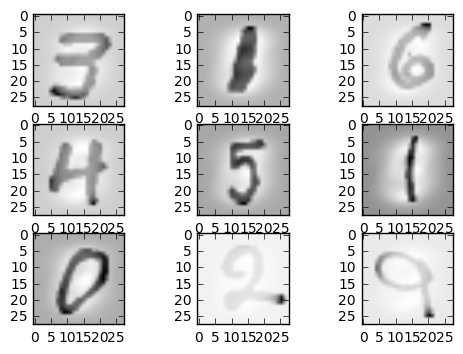

[3 1 6 4 5 1 0 2 9]


In [76]:
for i in range(9):
    plt.subplot(331+i)
    plt.imshow(X_train.reshape(-1,1,28,28)[i][0], cmap=cm.binary)
plt.show()
print target[2000:2009]

**Convolution Architecture**: 
Conv $\rightarrow$
Conv $\rightarrow$
Pool $\rightarrow$
Dropout$\rightarrow$
Flatten $\rightarrow$
Hidden $\rightarrow$
Dropout $\rightarrow$
Output

In [77]:
# Convolutional architecture ~conv, conv, pool, drop, flatten, dense, drop, dense~
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(28,28,1), activation='relu',
                       border_mode = 'valid'))
model.add(Convolution2D(32, 3, 3, border_mode='same'))
model.add(MaxPooling2D(pool_size=(2,2), dim_ordering='th'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

among *RMSprop*, *Adam*, *Adagrad*, *SGD*, *adadelta*, the best optimizer for this particular model was ***Adadelta***

In [79]:
num_epochs = 25
model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])

**mini batches:** *128*

**epochs:** *25*

Train on 40000 samples, validate on 2000 samples
Epoch 1/25
40000/40000 [==============================] - 139s - loss: 0.3754 - acc: 0.8866 - val_loss: 0.1105 - val_acc: 0.9640
Epoch 2/25
40000/40000 [==============================] - 138s - loss: 0.1368 - acc: 0.9594 - val_loss: 0.0671 - val_acc: 0.9795
Epoch 3/25
40000/40000 [==============================] - 138s - loss: 0.0997 - acc: 0.9697 - val_loss: 0.0467 - val_acc: 0.9850
Epoch 4/25
40000/40000 [==============================] - 132s - loss: 0.0784 - acc: 0.9779 - val_loss: 0.0387 - val_acc: 0.9920
Epoch 5/25
40000/40000 [==============================] - 130s - loss: 0.0678 - acc: 0.9805 - val_loss: 0.0336 - val_acc: 0.9885
Epoch 6/25
40000/40000 [==============================] - 136s - loss: 0.0597 - acc: 0.9819 - val_loss: 0.0297 - val_acc: 0.9925
Epoch 7/25
40000/40000 [==============================] - 132s - loss: 0.0528 - acc: 0.9839 - val_loss: 0.0341 - val_acc: 0.9900
Epoch 8/25
40000/40000 [========================

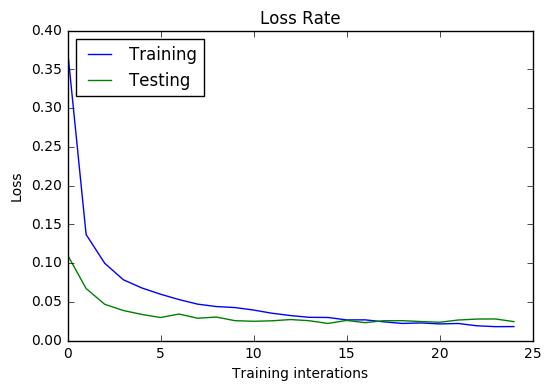

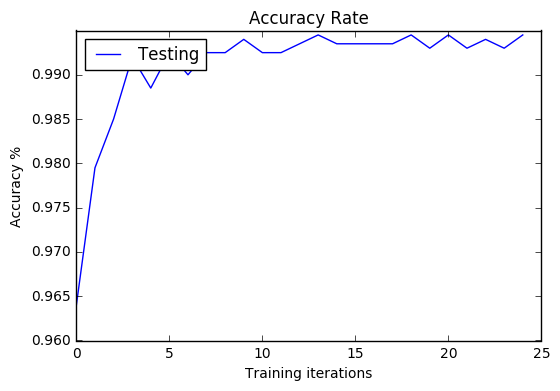

In [80]:
hist = model.fit(X_train,y_train, batch_size=128, nb_epoch=25, 
                validation_data=(X_valid,y_valid))
scores = model.evaluate(X_valid, y_valid, verbose=0)


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Rate')
plt.ylabel('Loss')
plt.xlabel('Training interations')
plt.legend(['Training', 'Testing'], loc='upper left')
plt.show()
plt.savefig('MNIST_loss_plot1.png')

plt.plot(hist.history['val_acc'])
plt.title('Accuracy Rate')
plt.ylabel('Accuracy %')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')
plt.show()
plt.savefig('MNIST_acc_plot1.png')

In [81]:
# save weights
model.save_weights('MNIST-weights.hdf5')

In [82]:
# load test data
test_data = pd.read_csv('test.csv').values.astype('float32')
test_data = StandardScaler().fit(test_data).transform(test_data)
test_data = test_data.reshape(-1,28,28,1)

In [83]:
# predictive model
test_submission = model.predict_classes(test_data, verbose=2)

We can print some of images from the test set and print the corresponding predicttions to get a sense of how good our model really was

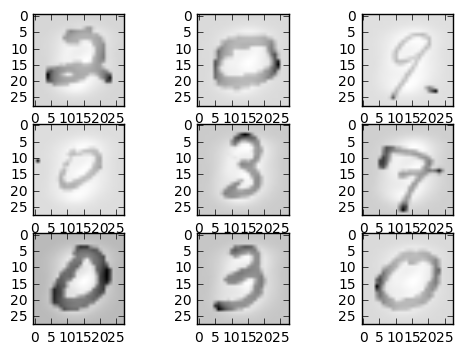

array([2, 0, 9, 0, 3, 7, 0, 3, 0])

In [84]:
for i in range(9):
    plt.subplot(330+i+1)
    plt.imshow(test_data.reshape(-1,1,28,28)[i][0],cmap=cm.binary)
plt.show()
test_submission[:9]

Results from our submission: **0.98657**


In [85]:
# save submission to csv
pd.DataFrame({"ImageId": list(range(1,len(test_data)+1)), 
              "Label": test_submission}).to_csv('MNIST-submission_1-3-2017.csv', index=False,header=True)